## Kaggle Titanic Sample
This is my first attempt at the titanic survival project. Given a data set of passengers with information like gender, age, class, and survival (0,1), we can create a model to predict whether a passenger would have survived on the titanic

link to online prompt:
kaggle: https://www.kaggle.com/c/titanic/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#statsmodels doesnt have an summary function for logit regressions, so we will import this fix
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
#read the training data file into "raw_data"
raw_data = pd.read_csv("train.csv")
raw_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Elias, Mr. Joseph Jr",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
#the following 5 cells are a couple of helpful methods to keep in mind of when doing some data exploration
#1
raw_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
#2
raw_data['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [5]:
#3
raw_data.groupby(raw_data['Survived']).mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


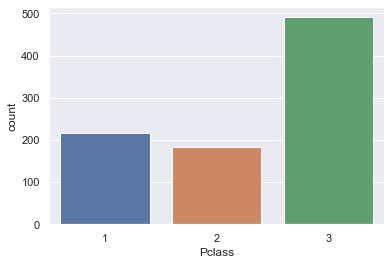

In [6]:
#4
sns.countplot(x = raw_data['Pclass'])
plt.show()

Text(0, 0.5, 'Frequency survival')

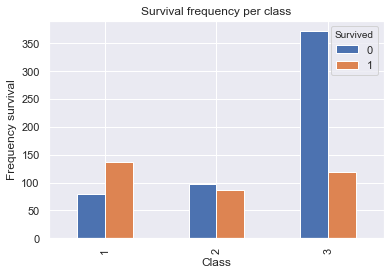

In [7]:
#5
#notice that we can either use raw_data["Pclass"] or raw_data.Pclass
#this graph informs us that mostly class 1 survived, and mostly class 3 did not. Good indicator for future model
pd.crosstab(raw_data.Pclass,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency per class')
plt.xlabel('Class')
plt.ylabel('Frequency survival')


Text(0, 0.5, 'Frequency survival')

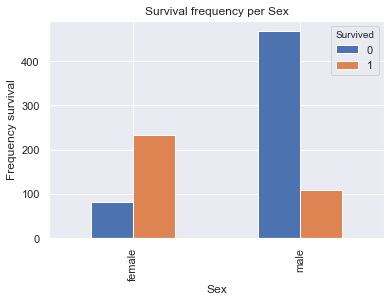

In [8]:
#6
#This informs us more likely to survive if female. Good indicator for our future model
pd.crosstab(raw_data.Sex,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency per Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency survival')

Text(0, 0.5, 'Frequency survival')

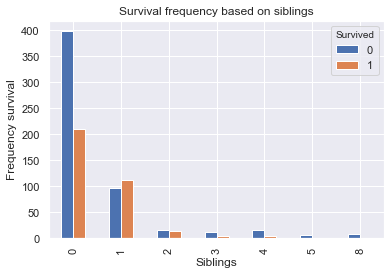

In [9]:
#7
#While a lot of people with 0 siblings survived, it also looks like 0 was the most common attribute. might not be helpful
pd.crosstab(raw_data.SibSp,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency based on siblings')
plt.xlabel('Siblings')
plt.ylabel('Frequency survival')

Text(0, 0.5, 'Frequency survival')

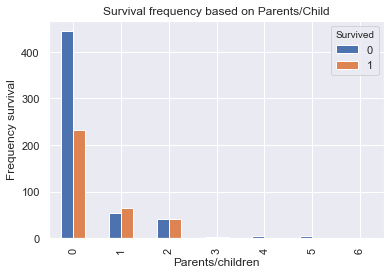

In [10]:
#8
#very similar result to above. might not be helpful
pd.crosstab(raw_data.Parch,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency based on Parents/Child')
plt.xlabel('Parents/children')
plt.ylabel('Frequency survival')

In [11]:
#Here we see 687 cabin entries are null out of possible 891, we should probably drop this column
#Missing 177 ages, we might want to find the mean and fill those in
raw_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
#lets create a copy of our data frame into "data" and make some changes

#transform the Sex feature into a binary value of 0 and 1
data = raw_data.copy()
data['Sex'] = data['Sex'].map({'male':0, 'female':1})
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891.000000,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,NaN,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Elias, Mr. Joseph Jr",NaN,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,0.352413,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,0.477990,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.000000,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,0.000000,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,0.000000,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,1.000000,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [13]:
#remove the Cabin column considering there are 687 missing values
data_no_cab = data.drop(['Cabin'], axis=1)

#remove Ticket column as this is unneccessary info
data_no_tick = data_no_cab.drop(['Ticket'], axis=1)

#remove Name column as this is unneccessary info
data_no_name = data_no_tick.drop(['Name'], axis=1)
data_no_name.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,644
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,NaN
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,NaN
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,NaN
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,NaN
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,NaN


In [14]:
#remove all entries where there is a null value, here we are specifically targetting where Age is null,
#considering age is a very important value for our model
data_no_mv = data_no_name.dropna(axis=0)
data_no_mv.describe(include = 'all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,554
mean,448.589888,0.404494,2.240169,0.363764,29.642093,0.514045,0.432584,34.567251,NaN
std,258.683191,0.491139,0.836854,0.481420,14.492933,0.930692,0.854181,52.938648,NaN
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN
25%,222.750000,0.000000,1.000000,0.000000,20.000000,0.000000,0.000000,8.050000,NaN
50%,445.000000,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.645850,NaN
75%,677.250000,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.000000,NaN


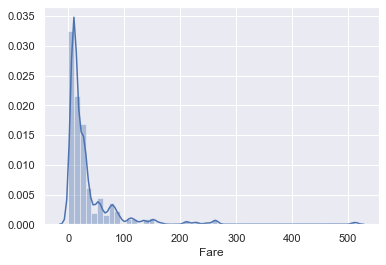

In [15]:
#running the distplot below we notice some serious outliers for Fare.
sns.distplot(data_no_mv['Fare'])

In [16]:
#because we noticed that there are some extreme outliers for Fare,
#we can use the pandas quantile function to fixate on a certain percentile of the data, and then use that number as a boundary.
#for this case, if we specify .99, we will return the price that is in the 99th percentile (~$262)
q1 = data_no_mv['Fare'].quantile(.99)

#then we create a copy of our data frame but only including prices that are below our q variable of $262
data_percentile1 = data_no_mv[data_no_mv['Fare']<q1]
data_percentile1.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550
mean,449.169275,0.399716,2.256046,0.361309,29.630398,0.500711,0.416785,30.580577,NaN
std,258.699093,0.490189,0.830261,0.480722,14.503376,0.918122,0.837921,37.441624,NaN
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN
25%,222.500000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,8.050000,NaN
50%,447.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,15.245800,NaN
75%,676.500000,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,31.331250,NaN


In [17]:
#lets do the same for Age
q2 = data_percentile1['Age'].quantile(.90)

#then we create a copy of our data frame but only including prices that are below our q variable of $262
data_percentile2 = data_percentile1[data_percentile1['Age']<q2]
data_percentile2.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,631.000000,631.00000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499
mean,450.166403,0.40412,2.334390,0.369255,26.463027,0.527734,0.437401,29.176194,NaN
std,260.762817,0.49111,0.803212,0.482986,11.448702,0.950576,0.863067,36.561937,NaN
min,1.000000,0.00000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN
25%,220.500000,0.00000,2.000000,0.000000,19.000000,0.000000,0.000000,8.050000,NaN
50%,441.000000,0.00000,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,NaN
75%,683.500000,1.00000,3.000000,1.000000,34.250000,1.000000,1.000000,30.285400,NaN


In [18]:
#lets do the same for Age
q3 = data_percentile2['SibSp'].quantile(.99)

#then we create a copy of our data frame but only including prices that are below our q variable of $262
data_percentile3 = data_percentile2[data_percentile2['SibSp']<q3]
data_percentile3.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480
mean,453.128289,0.414474,2.309211,0.371711,27.171332,0.388158,0.393092,28.951116,NaN
std,259.517154,0.493037,0.807572,0.483660,11.013616,0.629315,0.842694,37.189709,NaN
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,NaN
25%,225.750000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,7.925000,NaN
50%,443.500000,0.000000,3.000000,0.000000,27.000000,0.000000,0.000000,13.208350,NaN
75%,683.750000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,27.900000,NaN


In [19]:
#we have categorical data in Embarked that needs to be represented in our regression.
#to do this, we introduce dummies that will take the place of the categorical data
#if we have N categories, we need N-1 dummies, otherwise multicollinearity will be introduced
#to do this we use the get_dummies method and set drop_first=True so that we get N-1 dummies

data_with_dummies = pd.get_dummies(data_percentile3, drop_first=True)
data_with_dummies.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,0,1
1,2,1,1,1,38.0,1,0,71.2833,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,1


In [20]:
#Create new data frames of our target and inputs
PassIds = data_with_dummies['PassengerId']
targets = data_with_dummies['Survived']
inputs = data_with_dummies.drop(['PassengerId','Survived'], axis=1)

#inputs2 is a different set of features
inputs2 = inputs.drop(['Parch','Fare','Embarked_Q', 'Embarked_S'], axis=1)
inputs2

,Pclass,Sex,Age,SibSp
0,3,0,22.0,1
1,1,1,38.0,1
2,3,1,26.0,0
3,1,1,35.0,1
4,3,0,35.0,0
...,...,...,...,...
885,3,1,39.0,0
886,2,0,27.0,0
887,1,1,19.0,0
889,1,0,26.0,0


In [21]:
#lets standardize the features, Age and Fare features are significantly higher numerically than the others
#we import the standard scaler library, then create the scaler and fit it with x

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs2)

#next we actually standardized the values in x
inputs_scaled = scaler.transform(inputs2)
inputs_scaled

array([[ 0.85609522, -0.76917036, -0.4699265 ,  0.97303547],
       [-1.62250427,  1.30010211,  0.98401683,  0.97303547],
       [ 0.85609522,  1.30010211, -0.10644067, -0.61730207],
       ...,
       [-1.62250427,  1.30010211, -0.74254087, -0.61730207],
       [-1.62250427, -0.76917036, -0.10644067, -0.61730207],
       [ 0.85609522, -0.76917036,  0.43878808, -0.61730207]])

In [22]:
#cols = ['Pclass', 'Sex', 'Age','SibSp']
#x = data_cleaned[cols]
#y = data_cleaned['Survived']

#log_reg=sm.Logit(targets,inputs_scaled)
#results=log_reg.fit()
#print(results.summary2())

log_reg = LogisticRegression()
log_reg.fit(inputs_scaled,targets)


C:\Users\yoni.nackash\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_train_pred = log_reg.predict(inputs_scaled)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(targets, y_train_pred)
cnf_matrix

array([[303,  53],
       [ 64, 188]], dtype=int64)

In [24]:
raw_test_data = pd.read_csv("test.csv")
test_data = raw_test_data.copy()

test_data['Sex'] = test_data['Sex'].map({'male':0, 'female':1})
test_passengers = test_data['PassengerId']
test_inputs = test_data.drop(['PassengerId','Parch','Fare','Embarked','Cabin','Ticket','Name'], axis=1)
test_inputs

,Pclass,Sex,Age,SibSp
0,3,0,34.5,0
1,3,1,47.0,1
2,2,0,62.0,0
3,3,0,27.0,0
4,3,1,22.0,1
...,...,...,...,...
413,3,0,NaN,0
414,1,1,39.0,0
415,3,0,38.5,0
416,3,0,NaN,0


In [25]:
test_inputs = test_inputs.fillna(30)

In [26]:
scaler = StandardScaler()
scaler.fit(test_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

final_pred = log_reg.predict(test_inputs_scaled)

In [28]:
final_results = test_data.copy()
final_results

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,S


In [31]:
final_results1 = final_results.drop(['Pclass','Sex','Age','SibSp', 'Parch', 'Fare', 'Embarked','Name','Ticket','Cabin'], axis=1)
final_results1['Survived'] = final_pred
final_results1

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [32]:
final_results1.to_csv('output.csv', index=False)